<a href="https://colab.research.google.com/github/parthnaik13/NYRA/blob/main/4_1_POC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC 1

https://www.kaggle.com/competitions/big-data-derby-2022/overview

A univariate view of the load managment line of research to be explored for the Big Data Derby competition


Things to look at

1. Can we see any correlation between avg speeds of horses in races and their finish positions?
  * Is it appropriate to use avg race speeds as a horse performance criteria?

2. Horse performance over the race season
  * We are trying to see if there is a dip in the performance of horses in races as the race season progress (potentially due to the load the horse has to deal with due to the races it runs throughout the season), we use avg race speed as metric to gauge the performance of a horse
  * Select races on "Dirt" tracks and track condition is "FT"
  * Plot avg speeds for example horses across races from the start of the season to the end of the season (look at horses which have atleast 5 races per season)
    * Do we see the plots having a -ve slope?
    * Do we see differences between the slopes of the plots across different horses?



## Setup

* Mount google drive
* Load necessary python libraries
* Load the nyra_race_horse_speed.csv dataframe which contains race details for each horse along with its unique id, name, finish position and avg race speed, prepared in `3.1_Data_Prep.ipynb`

In [ ]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libs and print out their versions
import numpy as np
np.random.seed(7)

import pandas as pd
pd.set_option('display.max_columns', None) # Display all dataframe columns

import matplotlib
import matplotlib.pyplot as plt

print(f'numpy version - {np.__version__}')
print(f'pandas version - {pd.__version__}')
print(f'matplotlib version - {matplotlib.__version__}')

numpy version - 1.21.6
pandas version - 1.3.5
matplotlib version - 3.2.2


In [ ]:
# Load the nyra_race_horse_speed dataframe from drive
nyra_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/nyra_race_horse_speed.csv', index_col = 0)
print(f'Shape of the df - {nyra_df.shape}')
nyra_df.head(5)

Shape of the df - (15080, 18)


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed
0,AQU,2019-01-01,1,3,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190
1,AQU,2019-01-01,1,4,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696
2,AQU,2019-01-01,1,5,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390
3,AQU,2019-01-01,1,1,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308
4,AQU,2019-01-01,1,2,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267


In [ ]:
# Assign proper dtypes wherever needed
# race_date as datetime col
nyra_df['race_date'] = pd.to_datetime(nyra_df['race_date'])
# race_number as a int/numeric col
nyra_df['race_number'] = pd.to_numeric(nyra_df['race_number'])
# post_time as a datetime col
nyra_df['post_time'] = pd.to_datetime(nyra_df['post_time'])

## Avg race speeds vs finish positions

In [ ]:
# Get the rank for each horse for a race using the avg_race_speed
# The fastest horse will have a speed_rank of 1, the second fastest will have a speed_rank of 2
nyra_df['speed_rank'] = nyra_df.groupby(['track_id', 'race_date', 'race_number'])['avg_race_speed'].rank(method = 'dense', ascending = False)
nyra_df.loc[:, ['track_id', 'race_date', 'race_number', 'horse_id', 'finishing_place', 'speed_rank']].head(5)

,track_id,race_date,race_number,horse_id,finishing_place,speed_rank
0,AQU,2019-01-01,1,3,4,5.0
1,AQU,2019-01-01,1,4,5,4.0
2,AQU,2019-01-01,1,0,1,1.0
3,AQU,2019-01-01,1,1,2,2.0
4,AQU,2019-01-01,1,2,3,3.0


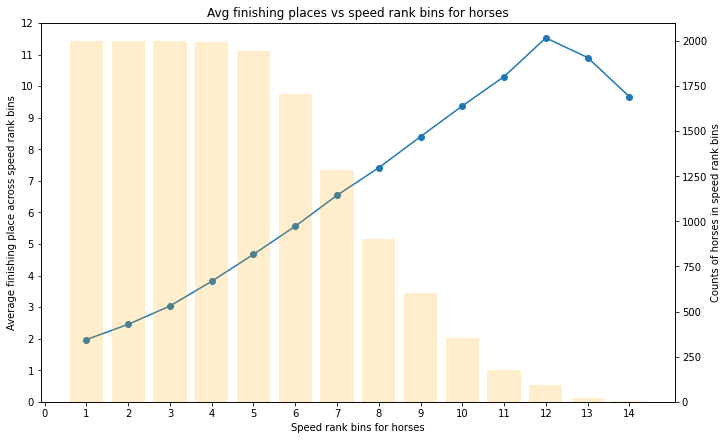

In [ ]:
# Plot avg finishing_place vs speed_rank
temp = nyra_df.groupby(['speed_rank']).agg({'finishing_place' : 'mean', 'horse_id' : 'count'}).reset_index()
temp = temp.rename(columns = {'finishing_place' : 'avg_finishing_place', 'horse_id' : 'horse_counts'})

# Init the figure and axes
fig, ax1 = plt.subplots(constrained_layout=True, figsize = (10,6))
ax2 = ax1.twinx()

# Plot speed rank bins vs avg_finishing_place 
ax1.plot(temp['speed_rank'], temp['avg_finishing_place'], 'o-')
ax1.set_xticks([i for i in range(15)])
ax1.set_yticks([i for i in range(13)])
ax1.set_ylabel('Average finishing place across speed rank bins')
ax1.set_xlabel('Speed rank bins for horses')
ax1.set_title('Avg finishing places vs speed rank bins for horses')

# Plot speed rank bins vs horse counts
ax2.bar(temp['speed_rank'], temp['horse_counts'], alpha = 0.2, color = 'orange')
ax2.set_ylabel('Counts of horses in speed rank bins')

plt.show()

* We definitely see a strong relationship between the speed ranks of horses vs their finishing places
* Looks like the avg_race_speed can be a viable metric for horse performance, having a string correlation with finishing place and might be free of other race winning factors like jockey skill (speed management, race path selection, other racing strategies)

## Horse performance over the race season

Do avg race speeds of horses change over the season? If so, is there any pattern?

### Filter to the most common types of horse races

This is to avoid avg speed variations due to track conditions


In [ ]:
# Filter the race data to the most common type of track condition - Dirt and Fast (avoid )
nyra_typical_races_df = nyra_df.loc[
    (nyra_df['course_type'] == 'D') &
    (nyra_df['track_condition'] == 'FT '),
    :
]

# Some details for the most typical race dataset
print(f'Shape of the filtered data - {nyra_typical_races_df.shape}')

num_races = nyra_typical_races_df.groupby(['track_id', 'race_date', 'race_number']).ngroups
print(f'Number of \'typical\' races - {num_races}')

Shape of the filtered data - (6990, 19)
Number of 'typical' races - 978


### Get the counts of these 'typical' races for horses

In [ ]:
# Get counts of typical races for horses
horse_typical_race_counts_df = nyra_typical_races_df.groupby('horse_id').agg({'race_number' : 'count'}).reset_index()
horse_typical_race_counts_df = horse_typical_race_counts_df.rename(columns = {'race_number' : 'race_counts'})
horse_typical_race_counts_df = horse_typical_race_counts_df.sort_values('race_counts', ascending = False)
horse_typical_race_counts_df.head(5)

,horse_id,race_counts
365,402,16
174,206,14
201,238,14
303,340,14
803,870,13


### Look at the speeds for high race count horses across the season

In [ ]:
def horse_season(races_df):
  """
  Function plots the avg speed for a horse across the 2019 season given races
  Input: df containing race data for horse of interest 
  """
  # Sort races by their dates
  races_df = races_df.sort_values('race_date', ascending = True)

  # Generate the performance plot

  # Create a avg race speed plot across the season with markers for venues / race tracks
  plt.figure(figsize = (12, 6))
  plt.plot(races_df['race_date'], races_df['avg_race_speed'], '--', color = 'black', alpha = 0.5)
  # Points to identify AQU races
  plt.scatter(races_df.loc[races_df['track_id'] == 'AQU', 'race_date'], races_df.loc[races_df['track_id'] == 'AQU', 'avg_race_speed'], s = 100, color = 'tab:brown', label = 'AQU race')
  # Points to identify BEL races
  plt.scatter(races_df.loc[races_df['track_id'] == 'BEL', 'race_date'], races_df.loc[races_df['track_id'] == 'BEL', 'avg_race_speed'], s = 100, color = 'tab:pink', label = 'BEL race')
  # Points to identify SAR races
  plt.scatter(races_df.loc[races_df['track_id'] == 'SAR', 'race_date'], races_df.loc[races_df['track_id'] == 'SAR', 'avg_race_speed'], s = 100, color = 'gold', label = 'SAR race')

  ax = plt.gca() # Get current axis (for the annotations)
  # Annotate finish positions
  for index, row in races_df.iterrows():
    ax.annotate(s = 'position : '+ str(row['finishing_place']), xy = (row['race_date'], row['avg_race_speed']), color = 'tab:cyan')

  # Show the legend
  plt.legend()
  # Axis labels
  plt.xlabel('Race date')
  plt.ylabel('Avg race speed')
  # Title
  horse_name = races_df['horse_name'].iloc[0]
  plt.title(f'Avg speed for {horse_name} for the 2019 race season')
  # Show the plot
  plt.show()

#### High race count examples

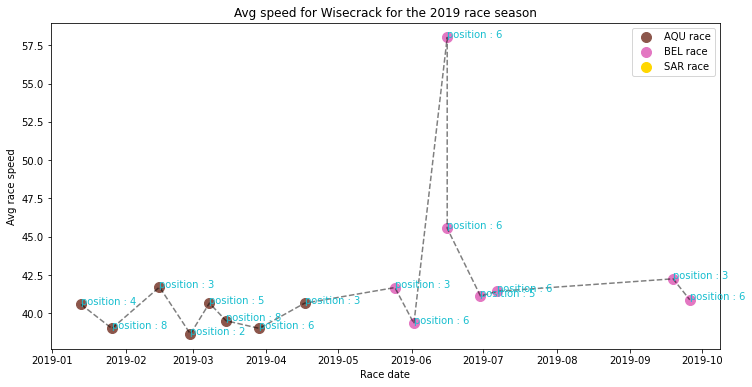

In [ ]:
horse_id = 402
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

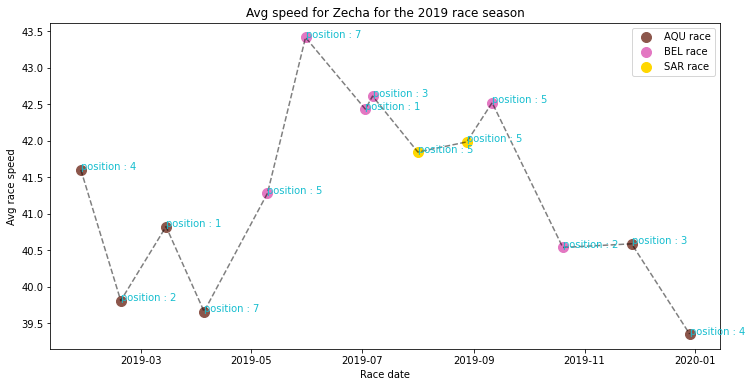

In [ ]:
horse_id = 206
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

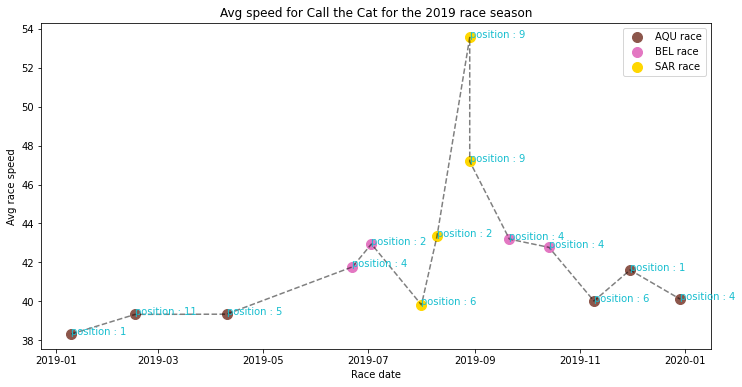

In [ ]:
horse_id = 238
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

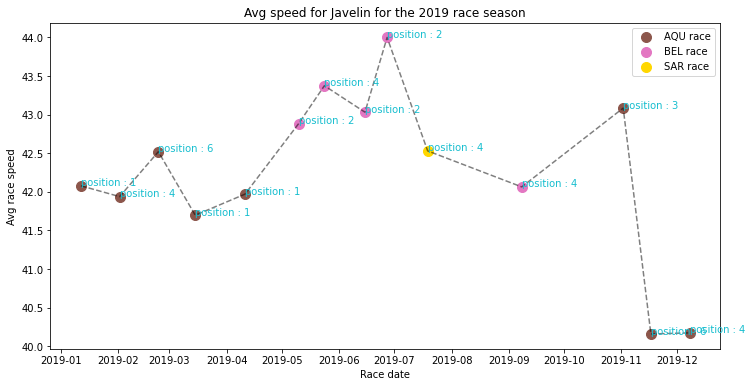

In [ ]:
horse_id = 340
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

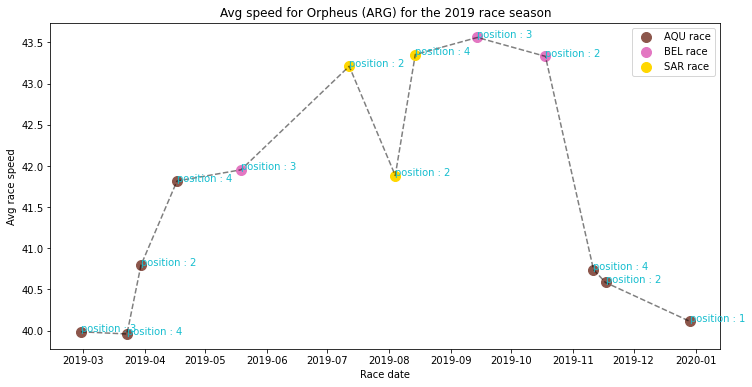

In [ ]:
horse_id = 870
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

#### Comparatively low number of races

In [110]:
horse_typical_race_counts_df.loc[horse_typical_race_counts_df['race_counts'] == 5, :].head(5)

,horse_id,race_counts
567,626,5
92,106,5
963,1037,5
967,1041,5
1860,2551,5


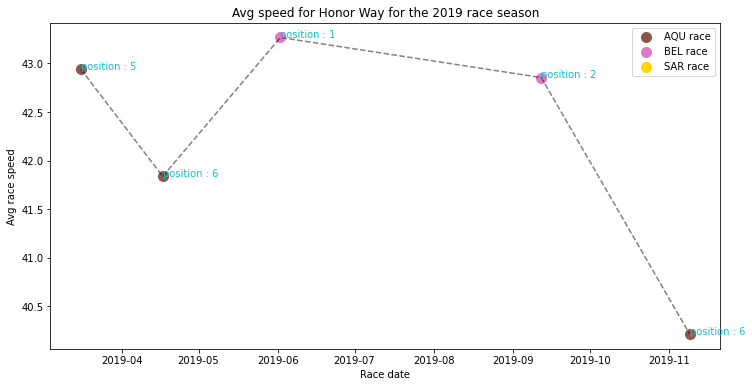

In [111]:
horse_id = 626
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

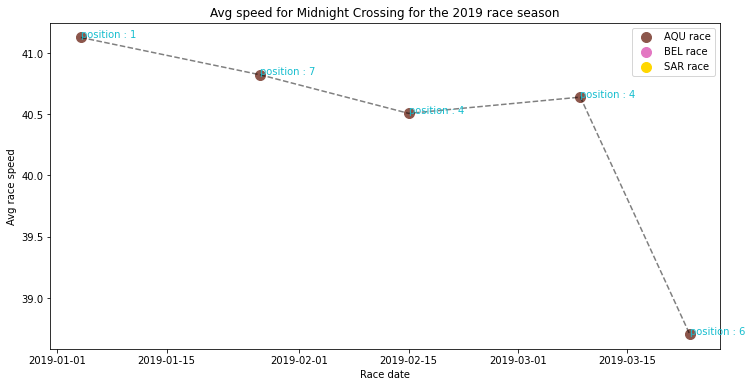

In [112]:
horse_id = 106
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

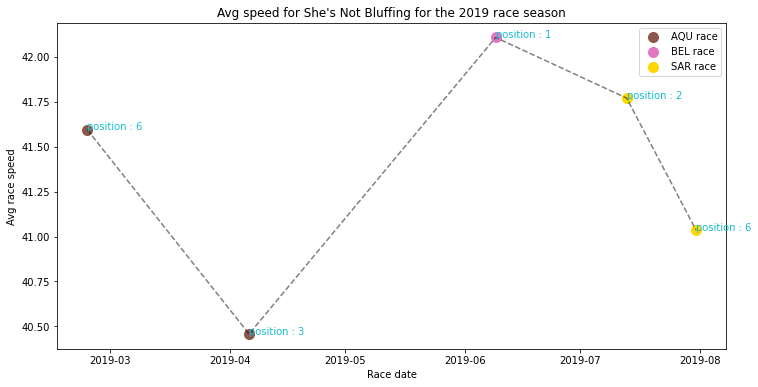

In [113]:
horse_id = 1037
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

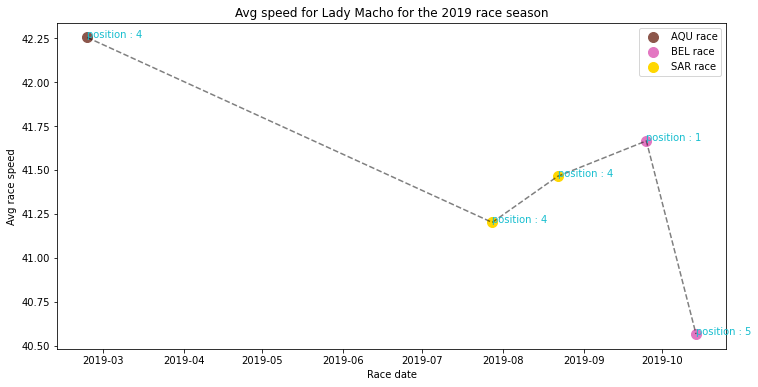

In [115]:
horse_id = 1041
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

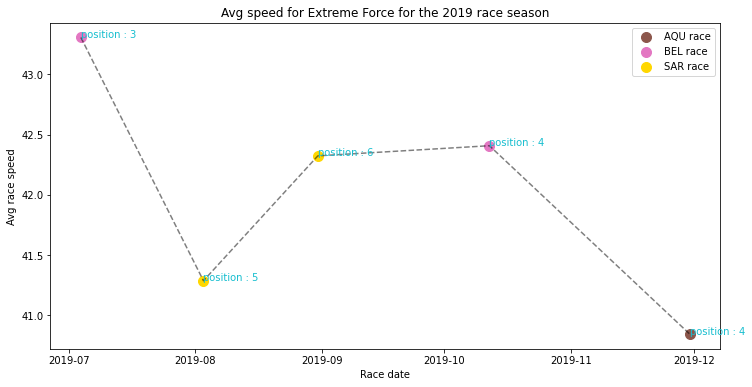

In [116]:
horse_id = 2551
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])